In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, Add, Dropout, Concatenate, Conv2DTranspose, Dense, Reshape, Flatten, Softmax, Lambda, UpSampling2D, AveragePooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
!pip install tensorflow-wavelets
import tensorflow_wavelets.Layers.DWT as DWT

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load dataset

#### Custom Dataloader

In [4]:
def load_image(path, size, mask=False):
    image = Image.open(path)
    image = image.resize((size, size))

    if mask:
        image = image.convert('L')  # Convert to grayscale
    else:
        image = image.convert('RGB')  # Convert to RGB
    
    image = np.array(image)
    return image

def load_data(root_path, size):
    images = []
    masks = []

    image_folder = os.path.join(root_path, 'masks')
    mask_folder = os.path.join(root_path, 'images')

    for image_path in sorted(glob(os.path.join(image_folder, '*png'))):
        img_id = os.path.basename(image_path).split('.')[0]
        mask_path = os.path.join(mask_folder, f'{img_id}.png')

        img = load_image(image_path, size) / 255.0
        mask = load_image(mask_path, size, mask=True) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [5]:
size = 512   # image size: 512x512
root_path = '/kaggle/input/tnbc-seg/TNBC_NucleiSegmentation'
X_train, y_train = load_data(root_path, size)

In [6]:
print(f"X shape: {X_train.shape}     |  y shape: {y_train.shape}")

# prepare data to modeling
# X = np.expand_dims(X, -1)
y_train = np.expand_dims(y_train, -1)

print(f"\nX shape: {X_train.shape}  |  y shape: {y_train.shape}")

X shape: (50, 512, 512, 3)     |  y shape: (50, 512, 512)

X shape: (50, 512, 512, 3)  |  y shape: (50, 512, 512, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
y_train_zeros = np.zeros((24,64,64,512))
y_test_zeros = np.zeros((14,64,64,512))
y_val_zeros = np.zeros((6,64,64,512))
y_train_out = np.zeros((24,512,512,1))
y_test_out = np.zeros((14,512,512,1))
y_val_out = np.zeros((6,512,512,1))

print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('y_train_zeros shape:',y_train_zeros.shape)
print('X_val shape:',X_val.shape)
print('y_val shape:',y_val.shape)
print('y_val_zeros shape:',y_val_zeros.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)
print('y_test_zeros shape:',y_test_zeros.shape)

X_train shape: (36, 512, 512, 3)
y_train shape: (36, 512, 512, 1)
y_train_zeros shape: (24, 64, 64, 512)
X_val shape: (9, 512, 512, 3)
y_val shape: (9, 512, 512, 1)
y_val_zeros shape: (6, 64, 64, 512)
X_test shape: (5, 512, 512, 3)
y_test shape: (5, 512, 512, 1)
y_test_zeros shape: (14, 64, 64, 512)


#### Visualization of training images

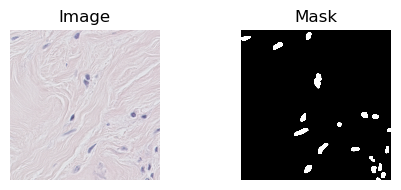

In [8]:
image = X_train[1]
mask = y_train[1]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of validation images

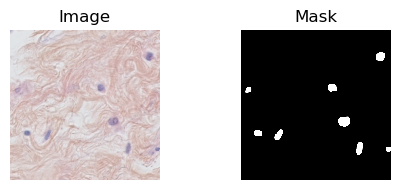

In [9]:
image = X_val[4]
mask = y_val[4]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

#### Visualization of testing images

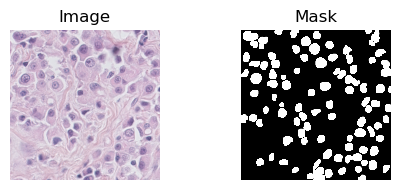

In [10]:
image = X_test[1]
mask = y_test[1]

fig, axes = plt.subplots(1, 2, figsize=(5, 2))
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Image')

axes[1].imshow(mask*255, cmap='gray', vmin=0, vmax=1)
axes[1].axis('off')
axes[1].set_title('Mask')

plt.tight_layout()
plt.show()

## Custom metrics and losses

#### Metrics

In [11]:
def dice_score(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return score

def iou(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(y_true_flat) + K.sum(y_pred_flat) - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def recall(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fn = K.sum(y_true_flat * (1 - y_pred_flat))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def precision(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fp = K.sum((1 - y_true_flat) * y_pred_flat)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision

#### Loss

In [12]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_score(y_true, y_pred)
    return loss

def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss
    
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = tf.reduce_mean(-focal_weight * tf.math.log(pt))
    return loss

def bce_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

def combined_loss(y_true, y_pred):
    loss = dice_loss(y_true, y_pred) + bce_loss(y_true, y_pred)
    return loss

# Custom UNet architecture

#### Instance Normalization

In [13]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        # Create a scale parameter and a shift parameter for each channel
        self.scale = self.add_weight(
            name='scale',
            shape=(input_shape[-1],),
            initializer='ones',
            trainable=True
        )
        self.shift = self.add_weight(
            name='shift',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        # Calculate mean and variance for each channel independently
        mean = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        variance = tf.reduce_mean(tf.square(inputs - mean), axis=[1, 2], keepdims=True)
        
        # Normalize the input
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        
        # Apply scale and shift
        output = self.scale * normalized + self.shift
        return output

#### Weighted GAP

In [14]:
class WeightedGlobalAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(WeightedGlobalAveragePooling2D, self).__init__(**kwargs)
        self.num_channels = num_channels
        # Create a trainable weight variable for each channel
        self.channel_weights = self.add_weight(name='channel_weights',
                                              shape=(num_channels,),
                                              initializer='ones',
                                              trainable=True)

    def call(self, inputs):
        # Calculate weighted global average pooling
        weighted_sum = tf.reduce_sum(inputs * self.channel_weights, axis=[1, 2])
        weighted_average = weighted_sum / tf.reduce_sum(self.channel_weights)
        return weighted_average

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_channels)

#### Gradients

In [15]:
class Gradients(L.Layer):
    def call(self, inputs):
        alpha = inputs
        gradients_alpha = tf.gradients(alpha, [alpha])[0]
        gradients_alpha = tf.reduce_mean(gradients_alpha, axis=[-1,-2, -3], keepdims=True)
        return gradients_alpha

#### WGCAM

In [16]:
def WGCAM(x):
    num_filters = x.shape[-1]
    wav = DWT.DWT(concat=0)(x)
    wav = Conv2DTranspose(num_filters*4, (2, 2), strides=2, padding="same")(wav)
    wav = SeparableConv2D(num_filters, (1,1), padding="same")(wav)
    x_sam = SeparableConv2D(num_filters, (1,1), padding="same")(x) 
    x_sam = wav+x_sam
    x_sam = SeparableConv2D(num_filters, (1,1), padding="same", activation='sigmoid')(x_sam)
    x_cam = WeightedGlobalAveragePooling2D(num_filters)(x)
    x_cam = Dense(num_filters/4, activation='relu')(x_cam)
    x_cam = Dense(num_filters, activation='sigmoid')(x_cam)
    x_cam = tf.keras.layers.Reshape((1, 1, x_cam.shape[-1]))(x_cam)
    x = x*x_sam
    x = tf.keras.layers.Multiply()([x, x_cam])
    return x

#### Modified pooling

In [17]:
def CombinedUpsampleLayer(inputs):
    _,H,W,C = inputs.shape
    gaussian = UpSampling2D(size=(2, 2), interpolation="gaussian")(inputs)
    lanczos = UpSampling2D(size=(2, 2), interpolation="lanczos5")(inputs)
    combined = tf.keras.layers.Add()([gaussian, lanczos])
    combined_attn = Conv2D(C, 1, padding="same")(combined)

    # Assuming you want to upsample to the original input size
    upsampled = Conv2DTranspose(C, (2, 2), strides=2, padding="same")(inputs)

    x = Concatenate()([combined_attn,upsampled])
    return x

#### Teacher

In [18]:
def conv_block(inputs, num_filters):
    x1 = Conv2D(num_filters//2, 5, padding="same")(inputs)
    x1 = InstanceNormalization()(x1)
    x1 = Activation("relu")(x1)
    
    x2 = Conv2D(num_filters//2, 3, padding="same")(inputs)
    x2 = InstanceNormalization()(x2)
    x2 = Activation("relu")(x2)
    
    x2 = Concatenate()([x1,x2])
    x2 = Conv2D(num_filters, 1, padding="same")(x2)
    
    x3 = Conv2D(num_filters, 1, padding="same")(inputs)
    x3 = InstanceNormalization()(x3)
    x3 = Activation("relu")(x3)
    
    x3 = Concatenate()([x2,x3])

    x = Conv2D(num_filters, 3, padding="same")(x3)
    x = InstanceNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = CombinedUpsampleLayer(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output    ## 128
    s4 = densenet.get_layer("pool3_relu").output    ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32
    b1 = WGCAM(b1)
    
    """ Decoder """
    d1 = decoder_block(b1, WGCAM(s4), 512)             ## 64
    d2 = decoder_block(d1, WGCAM(s3), 256)             ## 128
    d3 = decoder_block(d2, WGCAM(s2), 128)             ## 256
    d4 = decoder_block(d3, WGCAM(s1), 64)              ## 512

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name='TEACHER')
    return model
    
teacher_model = build_densenet121_unet((512, 512, 3))
optimizer = Adam(lr=0.0001)
teacher_model.compile(loss=combined_loss, metrics=["accuracy", dice_score, recall, precision, iou], optimizer=optimizer)
teacher_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "TEACHER"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [19]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/teacher.tf',
    monitor='val_dice_score',
    save_best_only=True,
    save_weight_only=True,
    mode='max',
    verbose=1
    )

history = teacher_model.fit(X_train, y_train,
                    epochs = 100,
                    batch_size = 2,
                    validation_data = (X_val,y_val),
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.3304 - accuracy: 0.8232 - dice_score: 0.4366 - recall: 0.7396 - precision: 0.4158 - iou: 0.2928
Epoch 1: val_dice_score improved from -inf to 0.19038, saving model to /kaggle/working/teacher.tf
18/18 [==============================] - 355s 12s/step - loss: 1.3304 - accuracy: 0.8232 - dice_score: 0.4366 - recall: 0.7396 - precision: 0.4158 - iou: 0.2928 - val_loss: 1.5693 - val_accuracy: 0.8427 - val_dice_score: 0.1904 - val_recall: 0.2575 - val_precision: 0.1992 - val_iou: 0.1093
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.1565 - accuracy: 0.9047 - dice_score: 0.5554 - recall: 0.7971 - precision: 0.5871 - iou: 0.4021
Epoch 2: val_dice_score did not improve from 0.19038
18/18 [==============================] - 123s 7s/step - loss: 1.1565 - accuracy: 0.9047 - dice_score: 0.5554 - recall: 0.7971 - precision: 0.5871 - iou: 0.4021 - val_loss: 1.7248 - val_accuracy: 0.7681 - val_dice_score: 0.06

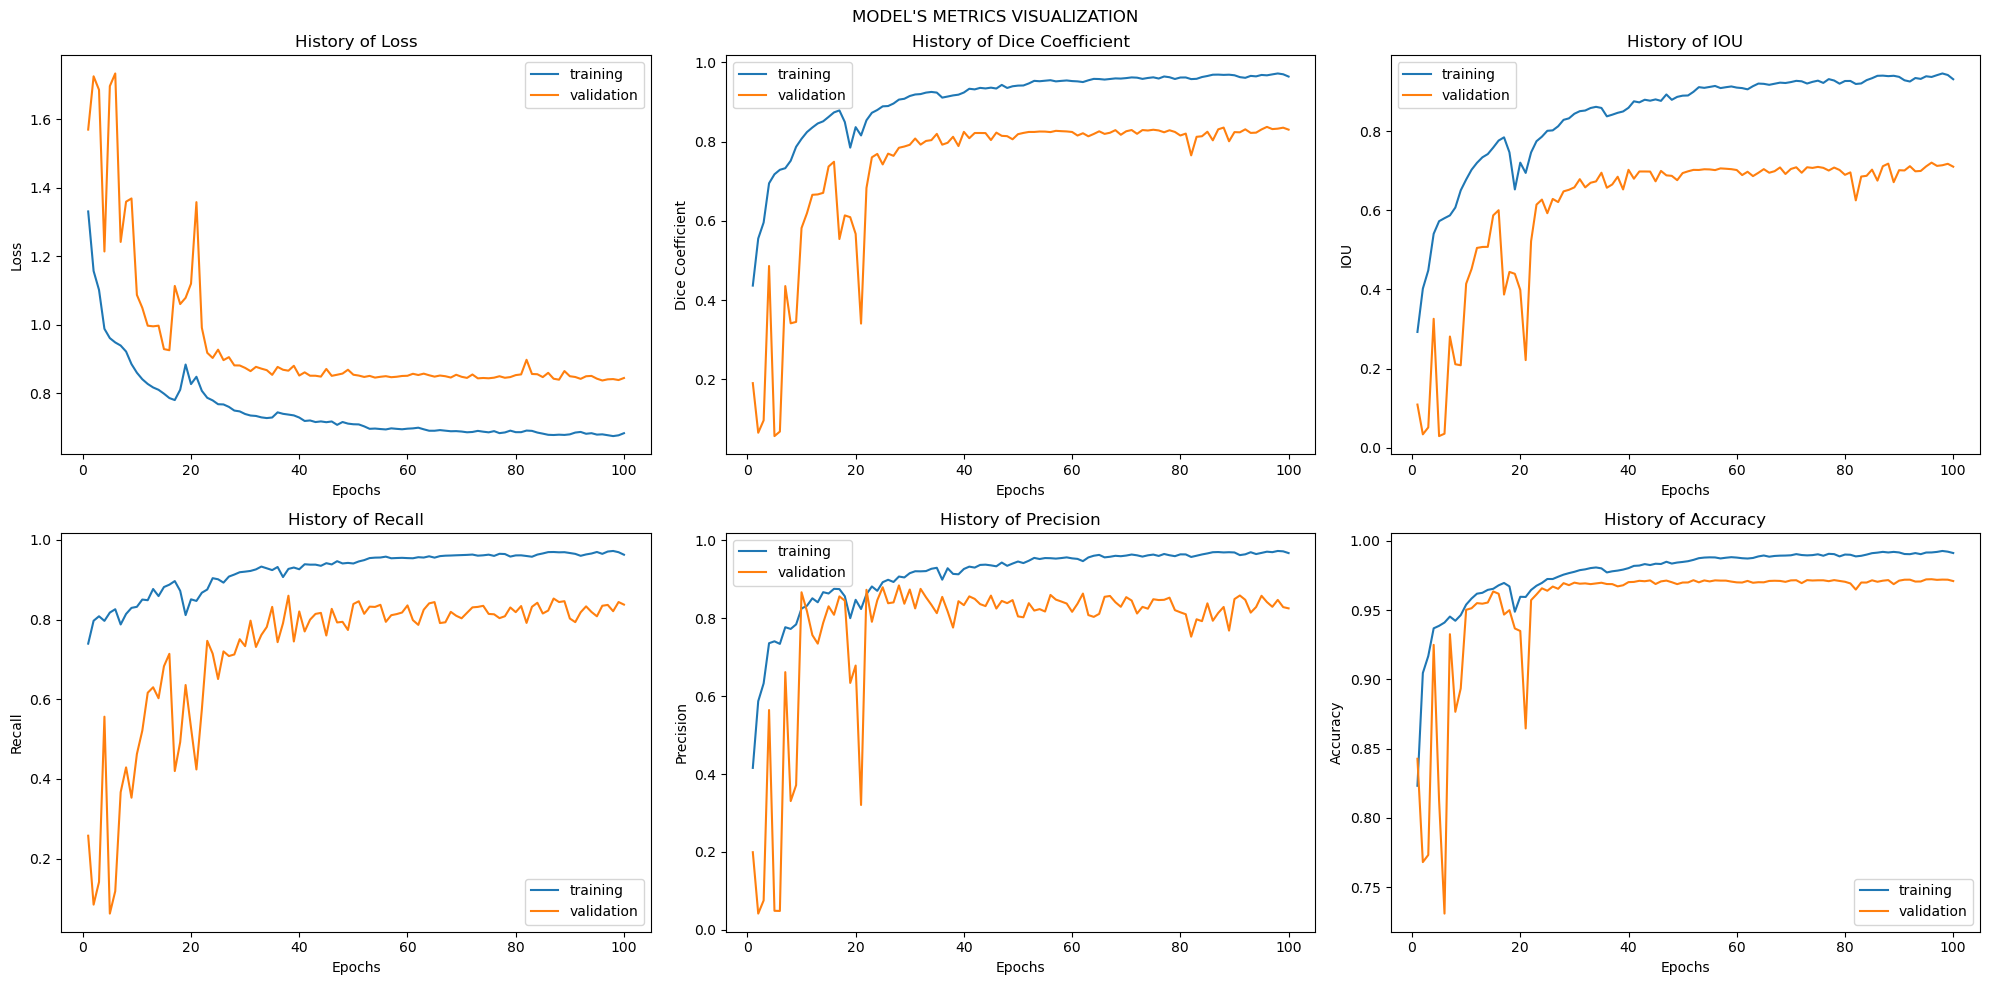

In [20]:
def Train_Val_Plot(loss, val_loss, dice_score, val_dice_score, iou, val_iou, recall, val_recall, precision, val_precision, accuracy, val_accuracy):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Loss plot
    axs[0, 0].plot(range(1, len(loss) + 1), loss)
    axs[0, 0].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 0].set_title('History of Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['training', 'validation'])

    # Dice Coefficient plot
    axs[0, 1].plot(range(1, len(dice_score) + 1), dice_score)
    axs[0, 1].plot(range(1, len(val_dice_score) + 1), val_dice_score)
    axs[0, 1].set_title('History of Dice Coefficient')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Dice Coefficient')
    axs[0, 1].legend(['training', 'validation'])

    # Mean IOU plot
    axs[0, 2].plot(range(1, len(iou) + 1), iou)
    axs[0, 2].plot(range(1, len(val_iou) + 1), val_iou)
    axs[0, 2].set_title('History of IOU')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('IOU')
    axs[0, 2].legend(['training', 'validation'])

    # Recall plot
    axs[1, 0].plot(range(1, len(recall) + 1), recall)
    axs[1, 0].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 0].set_title('History of Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['training', 'validation'])

    # Precision plot
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend(['training', 'validation'])

    # Accuracy plot
    axs[1, 2].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1, 2].plot(range(1, len(val_accuracy) + 1), val_accuracy)
    axs[1, 2].set_title('History of Accuracy')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('Accuracy')
    axs[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

Train_Val_Plot(
    history.history['loss'], history.history['val_loss'],
    history.history['dice_score'], history.history['val_dice_score'],
    history.history['iou'], history.history['val_iou'],
    history.history['recall'], history.history['val_recall'],
    history.history['precision'], history.history['val_precision'],
    history.history['accuracy'], history.history['val_accuracy']
)

In [21]:
teacher_model.load_weights("/kaggle/working/teacher.tf")
teacher_model.evaluate(X_test, y_test, batch_size = 1, verbose = 1)

5/5 [==============================] - 7s 1s/step - loss: 0.8456 - accuracy: 0.9536 - dice_score: 0.8165 - recall: 0.8143 - precision: 0.8259 - iou: 0.6918


[0.8455787897109985,
 0.9535812139511108,
 0.8164518475532532,
 0.8143342137336731,
 0.8258613348007202,
 0.6918388605117798]

#### Segmentation output Teacher

##### Spatial

In [22]:
modeller = Model(inputs=teacher_model.input, outputs=[teacher_model.get_layer(name="pool3_relu").output,teacher_model.get_layer(name="multiply").output,teacher_model.layers[-2].output])

1/1 [==============================] - 4s 4s/step


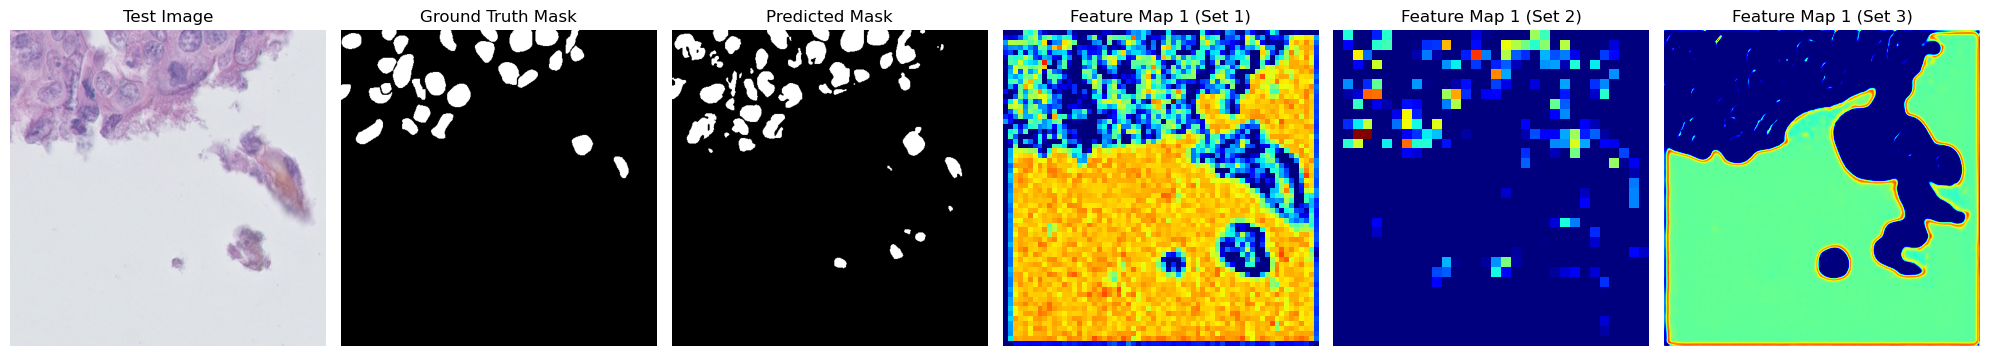

In [23]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[0]  # Replace X_test with your actual test dataset
test_mask = y_test[0]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


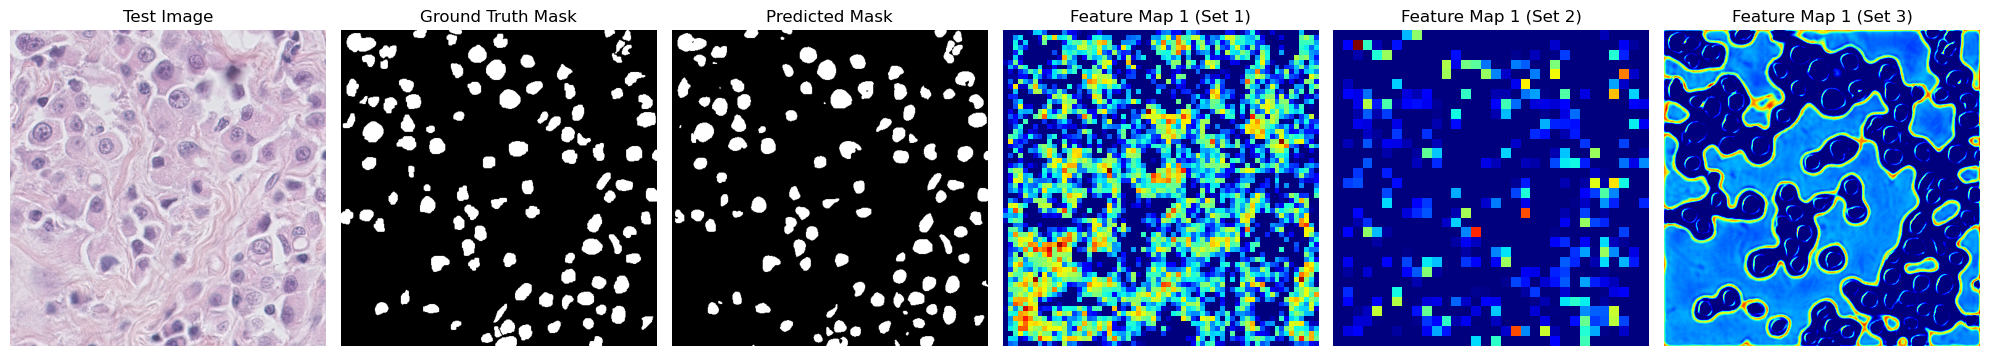

In [24]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[1]  # Replace X_test with your actual test dataset
test_mask = y_test[1]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step


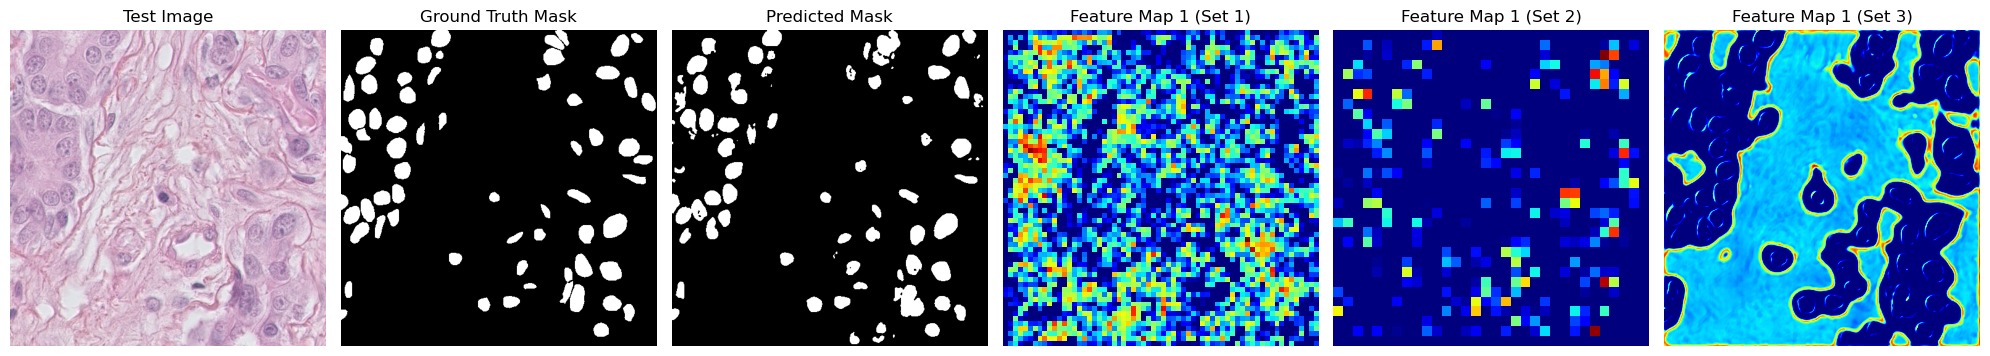

In [25]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[2]  # Replace X_test with your actual test dataset
test_mask = y_test[2]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()

##### DWT

In [26]:
modeller = Model(inputs=teacher_model.input, outputs=[teacher_model.get_layer(name="dwt_1").output,teacher_model.get_layer(name="dwt_2").output,teacher_model.get_layer(name="dwt_3").output])

1/1 [==============================] - 1s 747ms/step


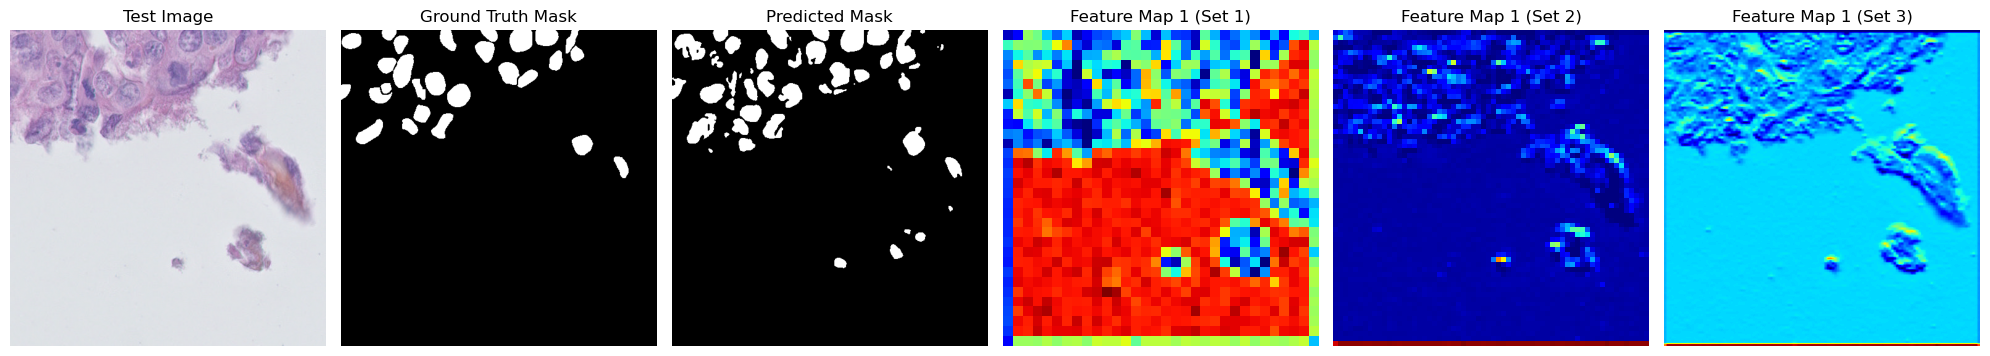

In [27]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[0]  # Replace X_test with your actual test dataset
test_mask = y_test[0]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 28ms/step


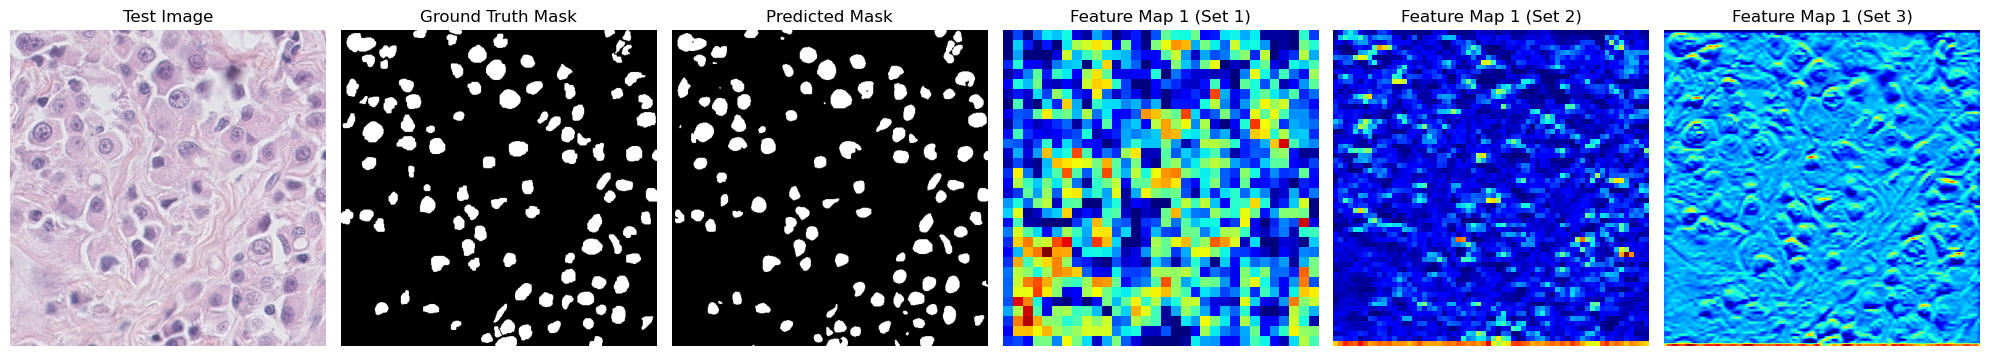

In [28]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[1]  # Replace X_test with your actual test dataset
test_mask = y_test[1]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 28ms/step


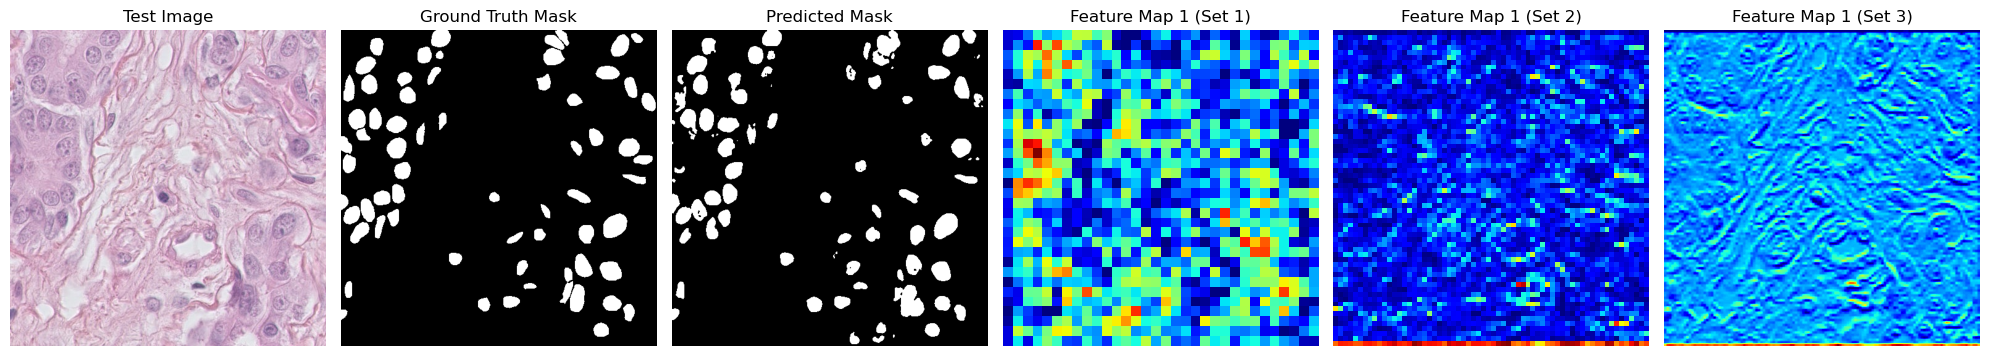

In [29]:
# Load one image and corresponding mask from the test dataset
test_image = X_test[2]  # Replace X_test with your actual test dataset
test_mask = y_test[2]  # Replace y_test with your actual test masks

# Reshape the image to match the input shape of the model
test_image = np.reshape(test_image, (1,) + test_image.shape)

# Predict the segmentation mask for the test image
predicted_mask = teacher_model.predict(test_image)[0]
feature_map1, feature_map2, feature_map3 = modeller.predict(test_image)

# Convert the predicted mask values to binary (0 or 1)
predicted_mask_binary = np.where(predicted_mask > 0.5, 1, 0) * 255

# Create subplots
fig, axes = plt.subplots(1, len(feature_map1) + 5, figsize=(20, 4))

# Plot the test image
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title('Test Image')
axes[0].axis('off')

# Plot the ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Plot the predicted mask
axes[2].imshow(predicted_mask_binary, cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

# Plot the feature maps (Set 1)
for i, fmap in enumerate(feature_map1):
    axes[i + 3].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3].set_title(f'Feature Map {i + 1} (Set 1)')
    axes[i + 3].axis('off')

# Plot the feature maps (Set 2)
for i, fmap in enumerate(feature_map2):
    axes[i + 3 + len(feature_map1)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1)].set_title(f'Feature Map {i + 1} (Set 2)')
    axes[i + 3 + len(feature_map1)].axis('off')

# Plot the feature maps (Set 3)
for i, fmap in enumerate(feature_map3):
    axes[i + 3 + len(feature_map1) + len(feature_map2)].imshow(fmap[:, :, 0], cmap='jet')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].set_title(f'Feature Map {i + 1} (Set 3)')
    axes[i + 3 + len(feature_map1) + len(feature_map2)].axis('off')

plt.tight_layout()
plt.show()